# Libraries

In [3]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [6]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from Utils import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [7]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [12]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [14]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [15]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:22<00:00,  3.26it/s]


In [16]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [16]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [17]:
def dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True):
    """Convert a DataFrame into a graph for GNN."""
    # Base node features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count']
    if include_small_molecules:
        features_to_include.append('Small_Molecules_Found')

    node_features = df[features_to_include].values

    # Optionally include coordinates as part of the node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])  # Combine features and coordinates

    node_features = torch.tensor(node_features, dtype=torch.float)

    # Build edges based on neighborhood radius
    coords = df[['X', 'Y', 'Z']].values  # Use coordinates for distance computation
    edge_index = []
    edge_attr = []

    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= neighborhood_radius:
                # Add bidirectional edges
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist])  # Use distance as edge feature
                edge_attr.append([dist])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)  # Shape: [num_edges, edge_features]

    # Graph data object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )

    return data


In [ ]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = dataframe_to_graph(df, neighborhood_radius=5.0, include_coordinates=True, include_small_molecules=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

In [19]:
graphs[2]

('data/all_nano_structures_single_domain/3g9a.pdb',
 Data(x=[355, 8], edge_index=[2, 940], edge_attr=[940, 1]))

In [20]:
import pickle 

# Save multiple graphs with associated PDB filenames
def save_graphs(graphs, output_dir='output_dir'):
    graphs_dir = os.path.join(output_dir, 'graphs')
    os.makedirs(graphs_dir, exist_ok=True)
    
    for pdb_file, graph in graphs:
        # Sanitize pdb_file to create a valid filename
        safe_filename = pdb_file.replace('/', '_').replace('\\', '_')
        filename = os.path.join(graphs_dir, f'{safe_filename}.pkl')
        with open(filename, 'wb') as file:
            pickle.dump(graph, file)
        print(f"Graph for {pdb_file} saved as {filename}")

# Load multiple graphs with associated PDB filenames
def load_graphs(output_dir='output_dir'):
    graphs_dir = os.path.join(output_dir, 'graphs')
    graphs = []
    
    for filename in sorted(os.listdir(graphs_dir)):
        if filename.endswith('.pkl'):
            pdb_file = filename.replace('.pkl', '').replace('_', '/')  # Reconstruct pdb_file
            with open(os.path.join(graphs_dir, filename), 'rb') as file:
                graph = pickle.load(file)
            graphs.append((pdb_file, graph))
            print(f"Loaded graph for {pdb_file} from {filename}")
    return graphs

In [21]:
# Example usage
# Assuming `graphs` contains tuples (pdb_file, graph)
save_graphs(graphs, output_dir='output_dir')

# When you want to reload:
#loaded_graphs = load_graphs(output_dir='output_dir')


Graph for data/all_nano_structures_single_domain/7l6v.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_7l6v.pdb.pkl
Graph for data/all_nano_structures_single_domain/6heq.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6heq.pdb.pkl
Graph for data/all_nano_structures_single_domain/3g9a.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_3g9a.pdb.pkl
Graph for data/all_nano_structures_single_domain/6hdb.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6hdb.pdb.pkl
Graph for data/all_nano_structures_single_domain/8hdp.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_8hdp.pdb.pkl
Graph for data/all_nano_structures_single_domain/4pou.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_4pou.pdb.pkl
Graph for data/all_nano_structures_single_domain/6vcb.pdb saved as output_dir/graphs/data_all_nano_structures_single_domain_6vcb.pdb.pkl
Graph for data/all_nano_structures_single

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Extract the PyTorch Geometric Data object from your graphs list
pdb_file, data = graphs[2]

# Convert to NetworkX for visualization
G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


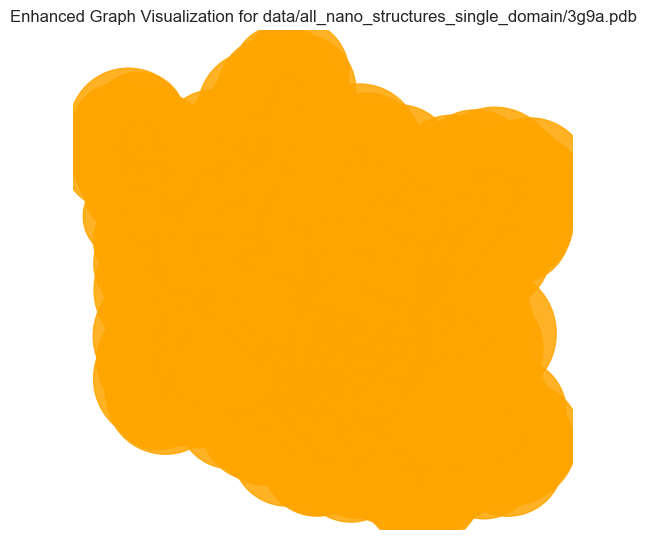

In [23]:
def visualize_graph(G, pdb_file, highlight_nodes=None):
    """Enhanced visualization with improved colors and visibility."""
    plt.figure(figsize=(5, 5))
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    
    # Add a title
    plt.title(f"Enhanced Graph Visualization for {pdb_file}")
    plt.show()

# Use the function
visualize_graph(G, pdb_file)


Pymol visualization of the same protein: 

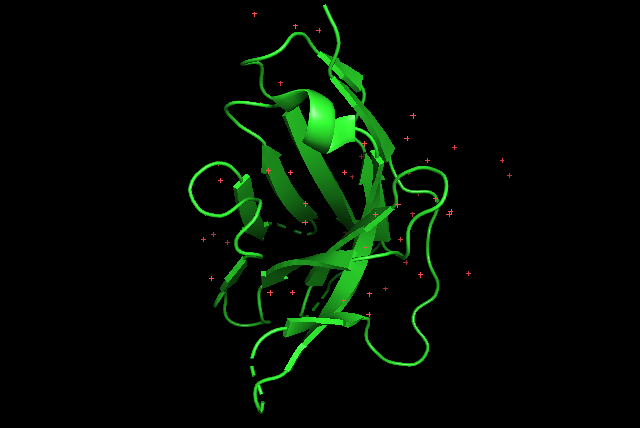

In [41]:
from IPython.display import Image, display

# Path to your PNG file
image_path = "data/8e1b_pymol_file.png"  # Replace with the actual path to your saved PNG

# Display the image
display(Image(filename=image_path))


DO the representation makes sense?

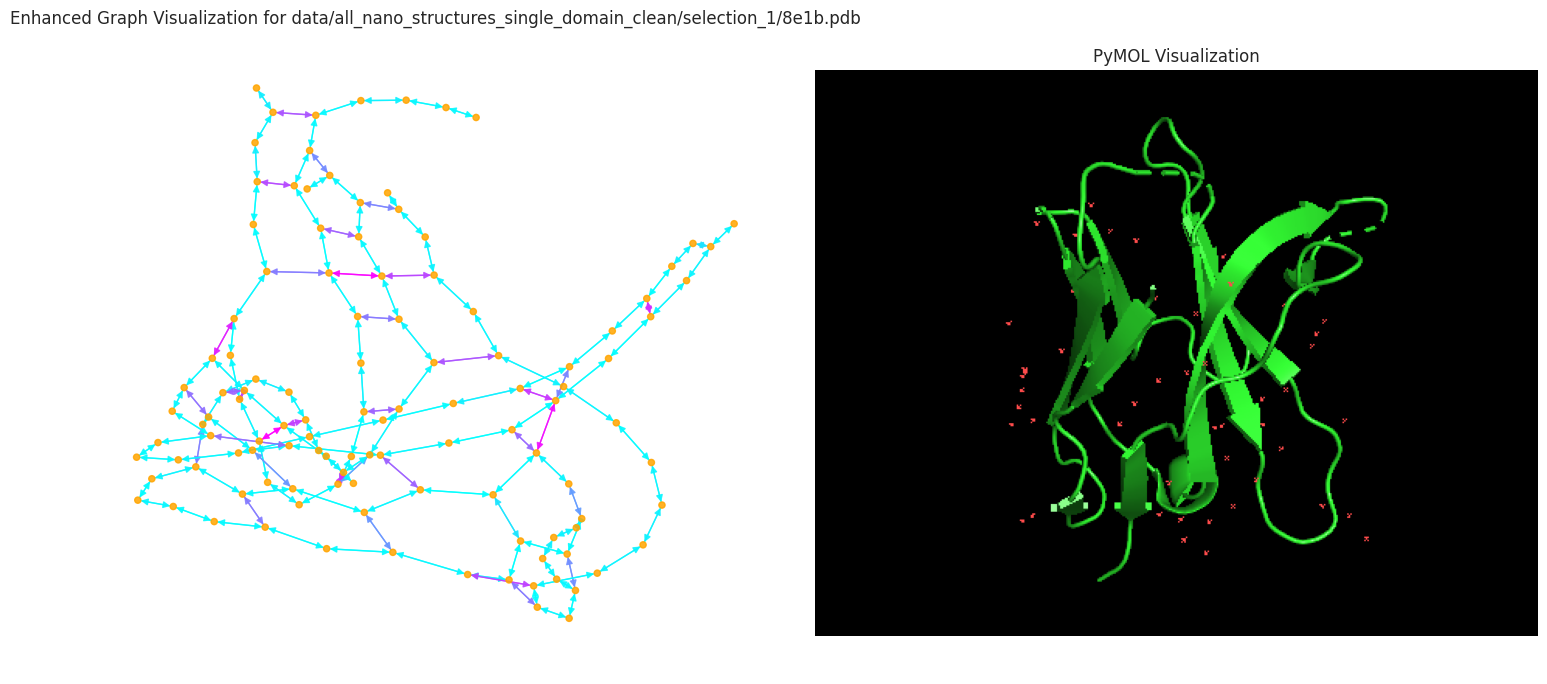

In [43]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_and_pymol(G, pdb_file, pymol_image_path, highlight_nodes=None):
    """Visualize the graph and PyMOL image side by side."""
    # Set up a side-by-side figure layout
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Visualization 1: Graph
    ax1 = axes[0]
    plt.sca(ax1)  # Set current axis to the first subplot
    
    # Use spring layout for better distribution
    pos = nx.spring_layout(G, seed=42)
    
    # Extract attributes for visualization
    node_sizes = [max(20, node[1]['x'][0] * 50) for node in G.nodes(data=True)]  # Scale and set a minimum size
    edge_weights = [max(0.5, edge[2]['edge_attr'][0] * 2) for edge in G.edges(data=True)]  # Scale and set a minimum width
    
    # Highlight specific nodes if provided
    if highlight_nodes:
        node_colors = [
            'red' if node in highlight_nodes else 'orange' for node in G.nodes
        ]
    else:
        node_colors = 'orange'
    
    # Draw the graph with enhanced visibility
    nx.draw(
        G,
        pos,
        ax=ax1,  # Plot on the current axis
        with_labels=False,
        node_size=node_sizes,
        edge_color=edge_weights,
        edge_cmap=plt.cm.cool,  # Use a more visible colormap
        node_color=node_colors,
        cmap=plt.cm.plasma,  # Distinguishable node colors
        alpha=0.85  # Set opacity for better visibility
    )
    ax1.set_title(f"Enhanced Graph Visualization for {pdb_file}")
    
    # Visualization 2: PyMOL Image
    ax2 = axes[1]
    ax2.axis('off')  # Turn off the axis for the image
    img = plt.imread(pymol_image_path)  # Read the PyMOL PNG image
    ax2.imshow(img)  # Display the image
    ax2.set_title("PyMOL Visualization")
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
visualize_graph_and_pymol(
    G, 
    pdb_file="data/all_nano_structures_single_domain_clean/selection_1/8e1b.pdb", 
    pymol_image_path="data/8e1b_pymol_file_rot.png"
)


Save the graph informations for overlay in pymol and verification of a meaningful graph creation: 

In [24]:
import pandas as pd

# Assuming `graph` is a single PyTorch Geometric Data object
def extract_graph_info(graph, feature_names):
    # Extract coordinates (last 3 columns if include_coordinates=True)
    coords = graph.x[:, -3:].numpy()  # Extract X, Y, Z coordinates
    
    # Extract node features
    features = graph.x[:, :-3].numpy()  # Remaining features (excluding coordinates)

    # Combine coordinates and features into a DataFrame
    data = pd.DataFrame(coords, columns=['X', 'Y', 'Z'])
    for i, feature_name in enumerate(feature_names[:-3]):  # Skip coordinate labels
        data[feature_name] = features[:, i]
    
    return data

# Example usage:
feature_names = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found', 'X', 'Y', 'Z']
graph_info_df = extract_graph_info(graph, feature_names)

# Save the DataFrame to a CSV for manual inspection or overlay
graph_info_df.to_csv("graph_info.csv", index=False)


# Dataloader

In [25]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8, seed=42):
    """
    Split the graphs into train and test datasets, and create DataLoaders for batching.

    Parameters:
    - graphs (list): List of `torch_geometric.data.Data` graphs.
    - batch_size (int): Batch size for the DataLoader.
    - train_ratio (float): Proportion of data to use for training.
    - seed (int): Random seed for reproducibility.

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the testing set.
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Split into train and test sets
    train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [26]:
# Example Usage
# If `graphs` already contains only `Data` objects, no need to unpack
train_loader, test_loader = split_and_batch_graphs(graphs, batch_size=16, train_ratio=0.8)

# Check the loaders
for batch in train_loader:
    print(batch)
    break


[('data/all_nano_structures_single_domain/4pou.pdb', 'data/all_nano_structures_single_domain/6wpw.pdb', 'data/all_nano_structures_single_domain/8wg8.pdb', 'data/all_nano_structures_single_domain/5c1m.pdb', 'data/all_nano_structures_single_domain/8ysf.pdb', 'data/all_nano_structures_single_domain/7nvo.pdb', 'data/all_nano_structures_single_domain/1ol0.pdb', 'data/all_nano_structures_single_domain/8et0.pdb', 'data/all_nano_structures_single_domain/7x2f.pdb', 'data/all_nano_structures_single_domain/4kml.pdb', 'data/all_nano_structures_single_domain/6oz6.pdb', 'data/all_nano_structures_single_domain/8v9w.pdb', 'data/all_nano_structures_single_domain/6heq.pdb', 'data/all_nano_structures_single_domain/8rmn.pdb', 'data/all_nano_structures_single_domain/7zkz.pdb', 'data/all_nano_structures_single_domain/7ul2.pdb'), DataBatch(x=[21083, 8], edge_index=[2, 52162], edge_attr=[52162, 1], batch=[21083], ptr=[17])]


Here's a breakdown of the components:

x=[20562, 8]: There are 20,562 nodes, each with 8 features (including optional 3D coordinates, average distances, etc., from your Data creation process).
edge_index=[2, 50880]: There are 50,880 edges in the batch, represented as a 2-row tensor where each column corresponds to an edge (source node, target node).
edge_attr=[50880, 1]: Each edge has 1 feature (likely the distance, as per your graph creation process).
batch=[20562]: This tensor indicates which graph each node belongs to, mapping each node to its graph in the batch.
ptr=[17]: This tensor provides pointers to the start indices of graphs in the batch. If you have 17 graphs in the batch, it means they have been concatenated into this single batch.
Interpretation:
This is a batched representation of your graphs, ready to be fed into a GNN model. Each component of the DataBatch provides the necessary information for processing multiple graphs simultaneously.

## Does this makes sense?

In typical machine learning scenarios like image processing, a "batch" contains a specific number of examples (e.g., 16 images in one batch). For your graph dataset, the batch contains multiple graphs, but they are combined into a single structure for efficient processing.

Here’s why it looks like "everything is together":

PyTorch Geometric combines all the nodes, edges, and features of the graphs in a batch into a single data structure.
The batch tensor within the DataBatch object is the key to separating the graphs. It tells the model which nodes and edges belong to which graph.
Let’s clarify this:

Example
If you batch 3 small graphs:

Graph 1: 4 nodes, 5 edges.
Graph 2: 3 nodes, 4 edges.
Graph 3: 5 nodes, 6 edges.
The batched result looks like this:

Nodes (x): Combined node features for all graphs, shape [12, features] (4+3+5 = 12 nodes).
Edges (edge_index): Combined edges, shape [2, 15] (5+4+6 = 15 edges).
Batch (batch): Tensor of size 12, assigning nodes to graphs, e.g., [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2].
Separation within a Batch
The batch tensor allows you to:

Identify which nodes belong to which graph.
Identify which edges are part of each graph.
The ptr tensor in the DataBatch object provides pointers to separate the graphs during training.

In [30]:
print(batch.ptr)  # Shows the start indices of each graph
num_graphs = len(batch.ptr) - 1
print(f"Number of graphs in the batch: {num_graphs}")

AttributeError: 'list' object has no attribute 'ptr'

In [34]:
# Check the structure of your data
sample_data = next(iter(train_loader))
print("Type of sample_data:", type(sample_data))
print("Content of sample_data:", sample_data[0] if isinstance(sample_data, list) else sample_data)

Type of sample_data: <class 'list'>
Content of sample_data: ('data/all_nano_structures_single_domain/6oca.pdb', 'data/all_nano_structures_single_domain/7wu3.pdb', 'data/all_nano_structures_single_domain/6ram.pdb', 'data/all_nano_structures_single_domain/7d4b.pdb', 'data/all_nano_structures_single_domain/5c1m.pdb', 'data/all_nano_structures_single_domain/7o06.pdb', 'data/all_nano_structures_single_domain/8k45.pdb', 'data/all_nano_structures_single_domain/7ckz.pdb', 'data/all_nano_structures_single_domain/8ug9.pdb', 'data/all_nano_structures_single_domain/7zkz.pdb', 'data/all_nano_structures_single_domain/8rmn.pdb', 'data/all_nano_structures_single_domain/1kxq.pdb', 'data/all_nano_structures_single_domain/6her.pdb', 'data/all_nano_structures_single_domain/6wpw.pdb', 'data/all_nano_structures_single_domain/8g7b.pdb', 'data/all_nano_structures_single_domain/8j1n.pdb')


In [35]:
# Check the structure of your data
#sample_data = next(iter(train_loader))
print("Type of sample_data:", type(graphs))
print("Content of sample_data:", graphs[0] if isinstance(sample_data, list) else sample_data)

Type of sample_data: <class 'list'>
Content of sample_data: ('data/all_nano_structures_single_domain/7l6v.pdb', Data(x=[1029, 8], edge_index=[2, 2720], edge_attr=[2720, 1]))


In [47]:
# Check the structure of your data
print("Type of graphs:", type(graphs))
print("Length of graphs:", len(graphs))
print("Type of first graph:", type(graphs[0]))
print("Content of first graph:", graphs[0])

Type of graphs: <class 'list'>
Length of graphs: 221
Type of first graph: <class 'tuple'>
Content of first graph: ('data/all_nano_structures_single_domain/7l6v.pdb', Data(x=[1029, 8], edge_index=[2, 2720], edge_attr=[2720, 1]))


In [54]:
# 1. Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [146]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)



In [147]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        # Update these weights in the __init__ method
        self.loss_weights = {
            'mass': 0.1,       # Reduced to prevent domination
            'distance': 0.1,   # Reduced for better balance
            'count': 0.1,      # Reduced for better balance
            'small_mol': 0.1,  # Reduced to prevent instability
            'coord': 0.1,      # Kept small for coordinates
            'edge': 0.1        # Reduced for balance
        }

        # Encoder
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(
                in_channels,
                hidden_channels,
                heads=num_heads,
                edge_dim=edge_dim,
                concat=True
            )
        ])

        self.encoder_conv2 = torch.nn.ModuleList([
            GATConv(
                hidden_channels * num_heads,
                hidden_channels,
                edge_dim=edge_dim,
                concat=False
            )
        ])

        # Encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Latent space
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()  # Constrain coordinates
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive mass
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()  # Ensure positive distances
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()  # Ensure positive count
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)  # No activation - using BCEWithLogitsLoss
        )

        # Edge decoder
        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()  # Ensure positive edge attributes
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Graph convolutions
        for conv in self.encoder_conv1:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        for conv in self.encoder_conv2:
            x = F.relu(conv(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.1, training=self.training)

        # Additional feature processing
        x = self.encoder_ff(x)

        # Pool and get latent parameters
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        position_noise = torch.randn_like(z) * 0.05  # Reduced noise
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Decode features
        h = self.shared_decoder(z)

        # Decode node features with specific activations
        coords = self.coord_head(h) * 10  # Scale coordinates
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Decode edge attributes
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6
    
        # Mass loss - using softplus for positive values
        mass_pred = F.softplus(recon[..., self.mass_index])  # Remove clamp
        mass_target = target[..., self.mass_index]
        # Use mean instead of max for more stable scaling
        mass_scale = mass_target.abs().mean() + EPS
        mass_pred_scaled = mass_pred / mass_scale
        mass_target_scaled = mass_target / mass_scale
        losses['mass'] = F.mse_loss(mass_pred_scaled, mass_target_scaled) * self.loss_weights['mass']
    
        # Distance loss
        dist_pred = F.softplus(recon[..., self.distance_indices])  # Remove clamp
        dist_target = target[..., self.distance_indices]
        dist_scale = dist_target.abs().mean() + EPS
        dist_pred_scaled = dist_pred / dist_scale
        dist_target_scaled = dist_target / dist_scale
        losses['distance'] = F.mse_loss(dist_pred_scaled, dist_target_scaled) * self.loss_weights['distance']
    
        # Count loss
        count_pred = F.softplus(recon[..., self.count_index])  # Remove clamp
        count_target = target[..., self.count_index]
        count_scale = count_target.abs().mean() + EPS
        count_pred_scaled = count_pred / count_scale
        count_target_scaled = count_target / count_scale
        losses['count'] = F.mse_loss(count_pred_scaled, count_target_scaled) * self.loss_weights['count']
    
        # Small molecules loss - binary cross entropy
        small_mol_pred = recon[..., self.small_mol_index]  # Remove clamp
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)  # Keep target binary
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred,
            small_mol_target,
            reduction='mean'
        ) * self.loss_weights['small_mol']
    
        # Coordinate loss - no activation needed
        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        coord_scale = coord_target.abs().mean() + EPS
        coord_pred_scaled = coord_pred / coord_scale
        coord_target_scaled = coord_target / coord_scale
        losses['coord'] = F.mse_loss(coord_pred_scaled, coord_target_scaled) * self.loss_weights['coord']
    
        # Edge loss
        edge_pred = F.softplus(edge_recon)  # Remove clamp
        edge_target_pos = F.softplus(edge_target)
        edge_scale = edge_target_pos.abs().mean() + EPS
        edge_pred_scaled = edge_pred / edge_scale
        edge_target_scaled = edge_target_pos / edge_scale
        losses['edge'] = F.mse_loss(edge_pred_scaled, edge_target_scaled) * self.loss_weights['edge']
    
        # Calculate total loss without clamping
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))
    
        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [148]:
def train_model(model, train_loader, test_loader, device, num_epochs=100, beta=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")

    history = {
        'train': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                  'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                  'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []},
        'test': {'total_loss': [], 'recon_loss': [], 'kl_loss': [],
                 'mass_loss': [], 'distance_loss': [], 'count_loss': [],
                 'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []}
    }

    from tqdm import tqdm
    import time

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses without clamping
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Combine losses without clamping
                loss = recon_loss + beta * kl_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                current_loss = loss.item()
                epoch_losses['total_loss'] += current_loss
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + beta * kl_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            if hasattr(plt, 'figure'):
                plt.figure(figsize=(20, 5))

                # Plot 1: Total, Reconstruction, and KL losses
                plt.subplot(1, 3, 1)
                plt.plot(history['train']['total_loss'], label='Total Loss')
                plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
                plt.plot(history['train']['kl_loss'], label='KL Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                # Plot 2: Feature-specific losses
                plt.subplot(1, 3, 2)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    plt.plot(history['train'][k], label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Feature-specific Losses')
                plt.legend()
                plt.grid(True)

                # Plot 3: Feature-specific losses (log scale)
                plt.subplot(1, 3, 3)
                for k in ['mass_loss', 'distance_loss', 'count_loss',
                          'small_mol_loss', 'coord_loss', 'edge_loss']:
                    values = [max(1e-10, abs(x)) for x in history['train'][k]]
                    plt.semilogy(values, label=k.replace('_loss', ''))
                plt.xlabel('Epoch')
                plt.ylabel('Loss (log scale)')
                plt.title('Feature-specific Losses (Log Scale)')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    print("\nTraining completed!")
    return model, history

In [149]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=32,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_conv1): ModuleList(
    (0): GATConv(8, 64, heads=4)
  )
  (encoder_conv2): ModuleList(
    (0): GATConv(256, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (coord_head): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 176
Number of test graphs: 45
Number of features per node: 8
Feature means: tensor([ 1.0179e-08, -1.5955e-08,  5.6615e-09,  6.4479e-09, -3.7243e-09,
         6.5408e-09,  2.3675e-08, -2.2946e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Starting training for 2 epochs...
Training on device: cpu
Number of training batches: 11
Number of validation batches: 3


Epoch 1/2 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([18190, 8])
Edge index shape: torch.Size([2, 45794])
Edge attr shape: torch.Size([45794, 1])
Reconstruction shape: torch.Size([16, 3531, 8])
Edge reconstruction shape: torch.Size([45794, 1])

Detailed loss diagnostics:
Raw recon_loss: 126.1759
Raw KL loss: 0.0024
mu mean: 0.0027, std: 0.0546
logvar mean: -0.0003, std: 0.0603
mass: 2.5677
distance: 2.1877
count: 119.5620
small_mol: 0.0718
coord: 1.6184
edge: 0.1683


Epoch 1/2 [Train]:  91%|█████████ | 10/11 [00:46<00:05,  5.90s/it, loss=18.3157, recon=18.3132, kl=0.0496] 


Detailed loss diagnostics:
Raw recon_loss: 166.4718
Raw KL loss: 0.0584
mu mean: 0.0276, std: 0.2654
logvar mean: 0.2389, std: 0.1503
mass: 3.8468
distance: 3.5558
count: 156.6323
small_mol: 0.0196
coord: 2.2680
edge: 0.1493


Epoch 1/2 [Train]: 100%|██████████| 11/11 [00:52<00:00,  4.80s/it, loss=166.4747, recon=166.4718, kl=0.0584]



Starting validation...


Epoch 1/2 [Valid]: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]



Epoch [1/2] - Time: 55.11s
Train - Total: 89.2824, Recon: 89.2815, KL: 0.0168
Feature Losses:
  mass_loss: 2.4438
  distance_loss: 2.2391
  count_loss: 83.1530
  small_mol_loss: 0.0529
  coord_loss: 1.2556
  edge_loss: 0.1372


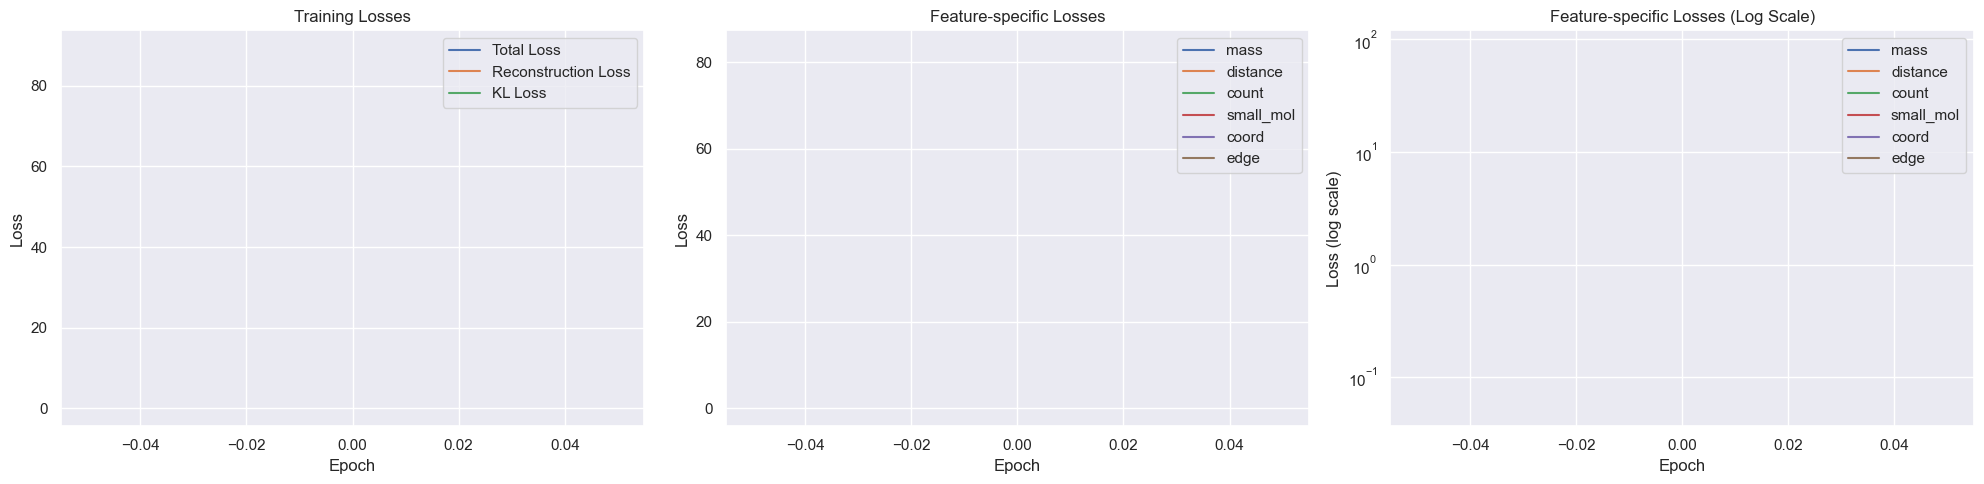

Epoch 2/2 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 84.2136
Raw KL loss: 0.0912
mu mean: 0.0333, std: 0.3275
logvar mean: 0.3011, std: 0.1831
mass: 1.9247
distance: 1.6775
count: 78.8798
small_mol: 0.0383
coord: 1.5480
edge: 0.1452


Epoch 2/2 [Train]:  91%|█████████ | 10/11 [00:45<00:05,  5.19s/it, loss=114.8208, recon=114.8089, kl=0.2380]


Detailed loss diagnostics:
Raw recon_loss: 8.0754
Raw KL loss: 0.2486
mu mean: 0.0498, std: 0.5152
logvar mean: 0.5135, std: 0.2773
mass: 1.0519
distance: 0.7905
count: 3.9578
small_mol: 0.0142
coord: 2.1853
edge: 0.0756


Epoch 2/2 [Train]: 100%|██████████| 11/11 [00:51<00:00,  4.65s/it, loss=8.0878, recon=8.0754, kl=0.2486]    



Starting validation...


Epoch 2/2 [Valid]: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]



Epoch [2/2] - Time: 53.39s
Train - Total: 69.6213, Recon: 69.6097, KL: 0.2303
Feature Losses:
  mass_loss: 1.7996
  distance_loss: 1.4510
  count_loss: 63.4498
  small_mol_loss: 0.0372
  coord_loss: 2.7392
  edge_loss: 0.1328


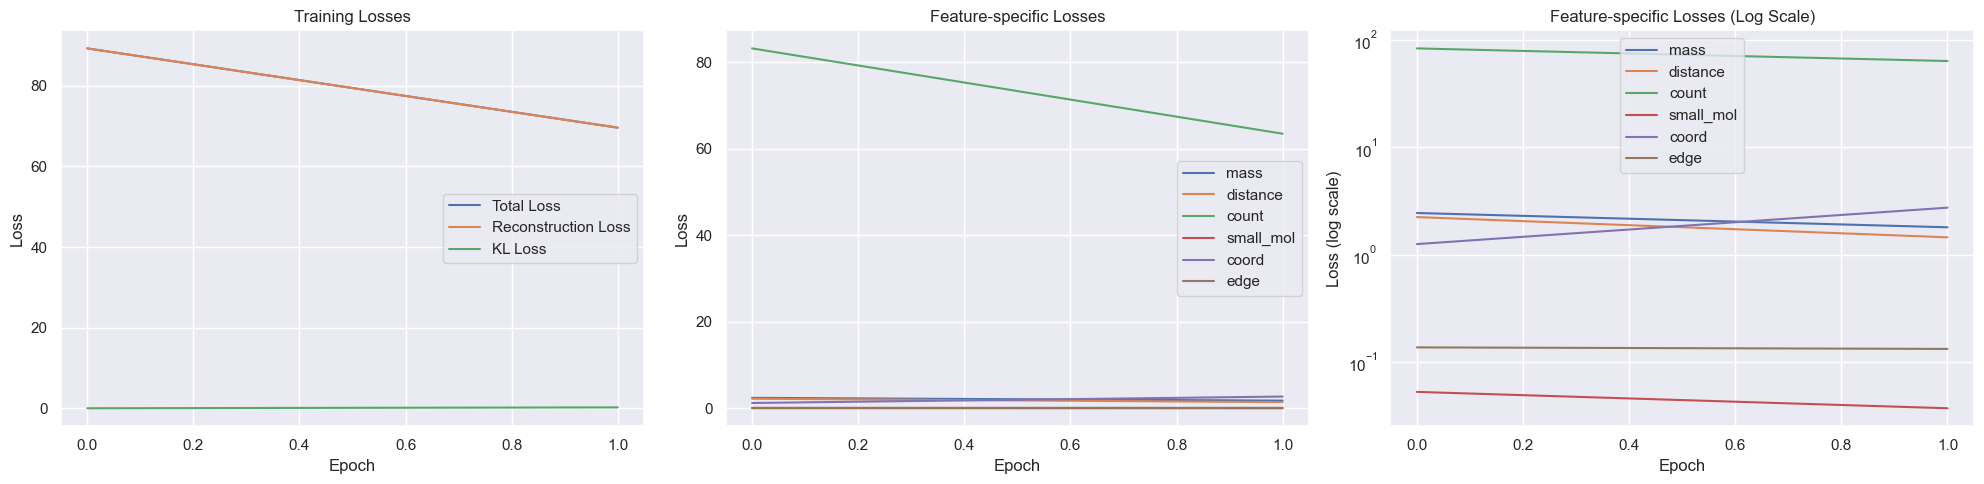


Training completed!


In [153]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=128,  # Increased capacity
    latent_channels=64,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.2,     # Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=2,    # More epochs
    beta=0.05        # Slightly increased KL weight
)

In [158]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)

        # Rest of your generation code remains the same...
        # [Previous code for edge generation and graph creation]

    return generated_graphs

def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


Graph Info
Node features shape: torch.Size([100, 8])
Edge index shape: torch.Size([2, 9900])

Feature statistics:
Mass range: 0.00 to 0.00
Avg Neighbor Dist range: 0.00 to 0.00
Max Neighbor Dist range: 0.00 to 0.00
Neighbor Count range: 0.00 to 0.00
Small Molecules ratio: -4.53

Sample nodes:

Node 0:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -4
  Coordinates: (-0.67, -0.66, 0.03)

Node 1:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (-0.67, -0.64, 0.03)

Node 2:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (-0.68, -0.63, 0.03)

Node 3:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (-0.66, -0.64, 0.02)

Node 4:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (-0.70, -0.65, 0.05)


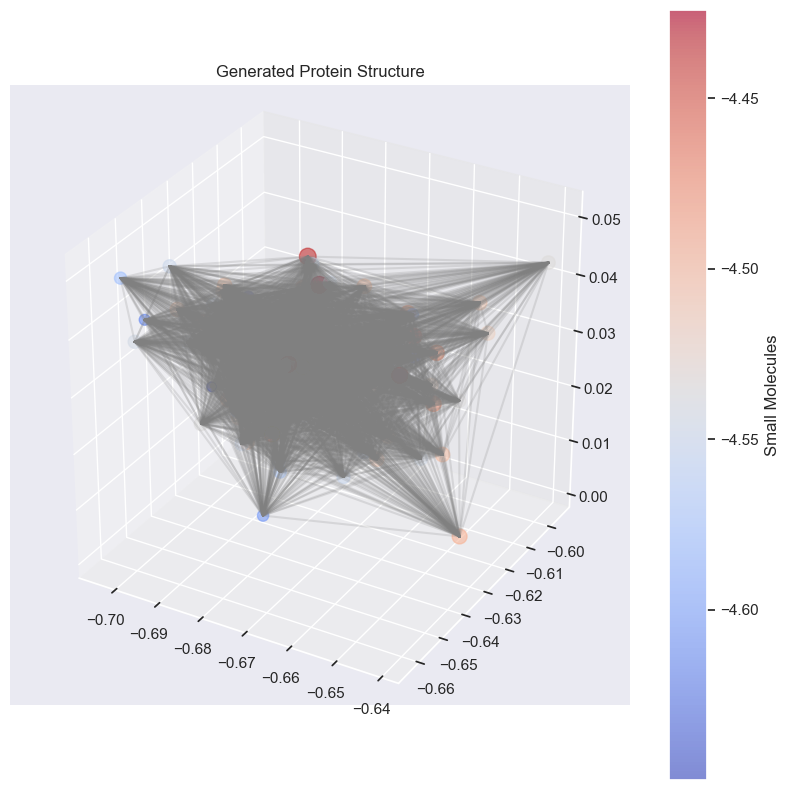

RuntimeError: expand(torch.FloatTensor{[1, 1, 1, 64]}, size=[-1, 1035, -1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [159]:
# Generate new proteins
generated_graphs = generate_protein_graphs(model, norm_params, num_samples=5, nodes_per_graph=100)


print_graph_info(generated[0])
visualize_protein_graph(generated[0])

# Or interpolate between proteins
interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)